<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instala e importa as bibliotecas

In [1]:
!pip install tensorflow-text

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text

# Importando DataSet

In [3]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df = pd.read_csv(url, delimiter=',', encoding='latin-1')
df.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Nova seção

# Preparação do DATASET
Limpa o DataSet e separa um sobconjunto dos dados para utilização no trabalho, a redução do número de linhas tem por propósito acelerar o processo de treinamento e manipulação dos dados.

In [4]:
df = df.head(10000)

In [5]:
df = df.dropna()
df = df.reset_index(drop=True)

In [6]:
rat=df.rating.value_counts()
rat

5    1854
1     642
4     510
3     291
2     238
Name: rating, dtype: int64

In [7]:
import matplotlib.pyplot as plt

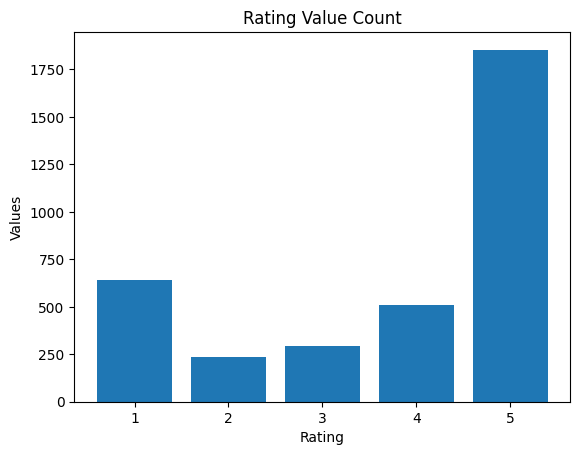

In [8]:
fig, ax = plt.subplots()
ax.bar(rat.index, rat.values)

# Set labels and title
ax.set_xlabel('Rating')
ax.set_ylabel('Values')
ax.set_title('Rating Value Count')

# Display the plot
plt.show()

In [9]:
import re
df["rating"] = df["rating"].astype(int)

In [10]:
#Para aumentar a acurácia e facilitar a tarefa de classificação, considerando a dificuldade em diferenciar classificações as classificações 1 e 2, assim como 4 e 5. Dessa forma
#resolvi converter 1 e 2 em "0" que significa uma avaliação negativa e 4 e 5 em "1" que significa uma classificação positiva, dessa forma vamos passar a abordar o problema como
#classificação binária.
mapping={1:0,2:0,3:None,4:1,5:1}
df.rating=df.rating.map(mapping)
df=df.dropna(subset='rating')

In [11]:
df["body"] = df["body"].str.encode("ascii", "ignore").str.decode("utf-8")

<ipython-input-11-a5dea9ad49dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body"] = df["body"].str.encode("ascii", "ignore").str.decode("utf-8")


In [12]:
df = df[["body", "rating"]]

In [13]:
df.head(10)

,body,rating
1,Due to a software issue between Nokia and Spri...,0.0
2,"This is a great, reliable phone. I also purcha...",1.0
4,The phone has been great for every purpose it ...,1.0
5,Cool. Cheap. Color: 3 words that describe the ...,1.0
6,"The 3599i is overall a nice phone, except that...",1.0
7,"I've never owned a Nokia phone before, so this...",1.0
9,I've had this phone for over a year and I real...,1.0
10,1.) Slow - If you want to check your missed ca...,0.0
11,I bought this phone about a year ago and have ...,0.0
12,This is an excellent choice for Sprint to use ...,1.0


# Separação em base de treino e teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.body,df.rating,test_size=0.2)

# Carrega o BERT preprocessor e encoder

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df.body[5],df.body[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.66974694, -0.55856156, -0.9775242 , ..., -0.939019  ,
        -0.6770846 ,  0.6674904 ],
       [-0.78146726, -0.6098954 , -0.9507825 , ..., -0.92656064,
        -0.7495821 ,  0.5948985 ]], dtype=float32)>

In [17]:
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [19]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [20]:
model.fit(X_train,y_train,epochs=1)

82/82 [==============================] - 34s 298ms/step - loss: 0.5936 - accuracy: 0.7233 - precision: 0.7289 - recall: 0.9862


In [21]:
model.evaluate(X_test,y_test)

21/21 [==============================] - 7s 292ms/step - loss: 0.5633 - accuracy: 0.7350 - precision: 0.7350 - recall: 1.0000


[0.5633377432823181, 0.7349768877029419, 0.7349768877029419, 1.0]

In [22]:
y_pred=model.predict(X_test)
y_pred=y_pred.flatten()

21/21 [==============================] - 7s 303ms/step


In [23]:
y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)

Text(50.722222222222214, 0.5, 'Truth')

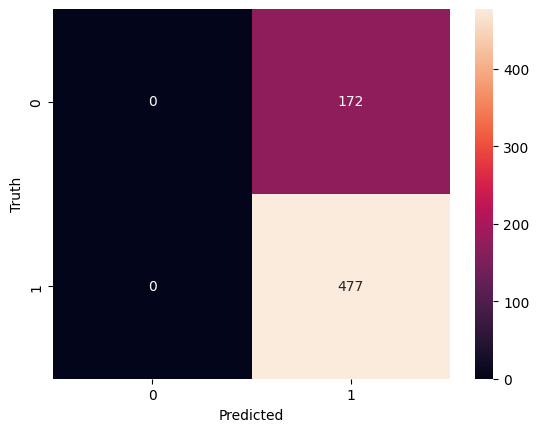

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       172
         1.0       0.73      1.00      0.85       477

    accuracy                           0.73       649
   macro avg       0.37      0.50      0.42       649
weighted avg       0.54      0.73      0.62       649



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
